In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import math

csv_dir = "./data_mod"
csv_files = [os.path.join(csv_dir, file) for file in os.listdir(csv_dir) if file.endswith('.csv')]

data_frame = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    data_frame = pd.concat([data_frame, df], ignore_index=True)



In [14]:
print("="*70)
print("Number of runs: ", len(csv_files))
print("Length of dataset: ", len(data_frame))
print("Average number of points per run: ", len(data_frame)/len(csv_files))
print("Average number of seconds per run: ", (len(data_frame)/len(csv_files)) / (1000/32) )
print("="*70)

print("Dataset fields: ", data_frame.columns)

Number of runs:  100
Length of dataset:  42578
Average number of points per run:  425.78
Average number of seconds per run:  13.62496
Dataset fields:  Index(['index', 'run_name', 'sim_time', 'x', 'y', 'z', 'roll', 'pitch', 'yaw',
       'gate_x', 'gate_y', 'gate_z', 'gate_yaw', 'vx_global', 'vy_global',
       'vz_global', 'vx_local', 'vy_local', 'roll_rate', 'pitch_rate',
       'yaw_rate', 'x_proj', 'y_proj', 'z_proj', 'x_sp', 'y_sp', 'z_sp',
       'vx_local_sp', 'vy_local_sp', 'alt_sp', 'yaw_rate_sp', 'alt_command',
       'roll_command', 'pitch_command', 'yaw_command', 'vx_ctrl_error',
       'vy_ctrl_error', 'alt_ctrl_error', 'roll_ctrl_error',
       'pitch_ctrl_error', 'yaw_rate_ctrl_error', 'camera_img', 'depth_img',
       'pencil_img'],
      dtype='object')


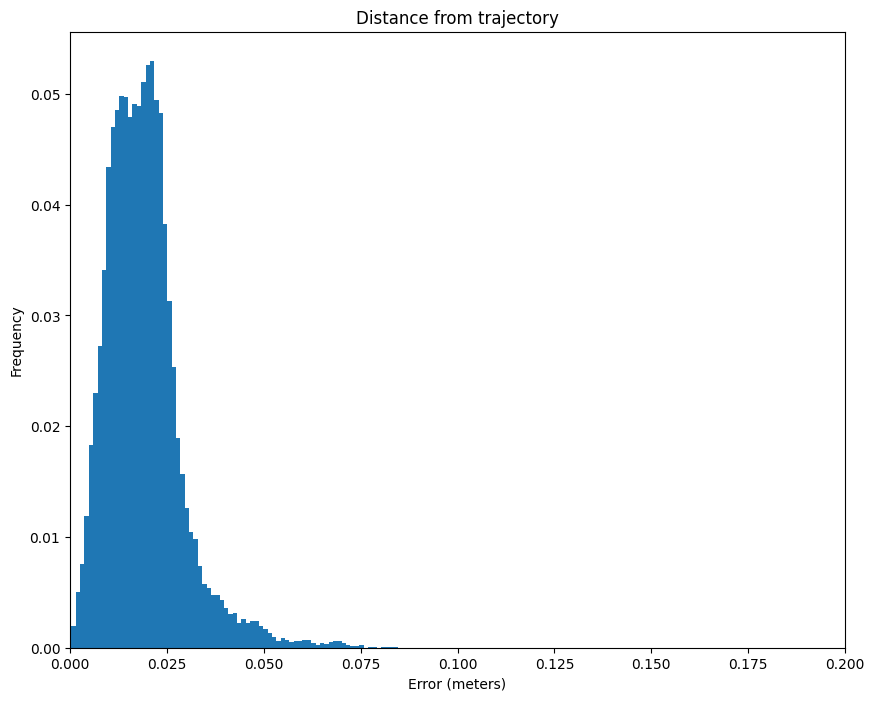

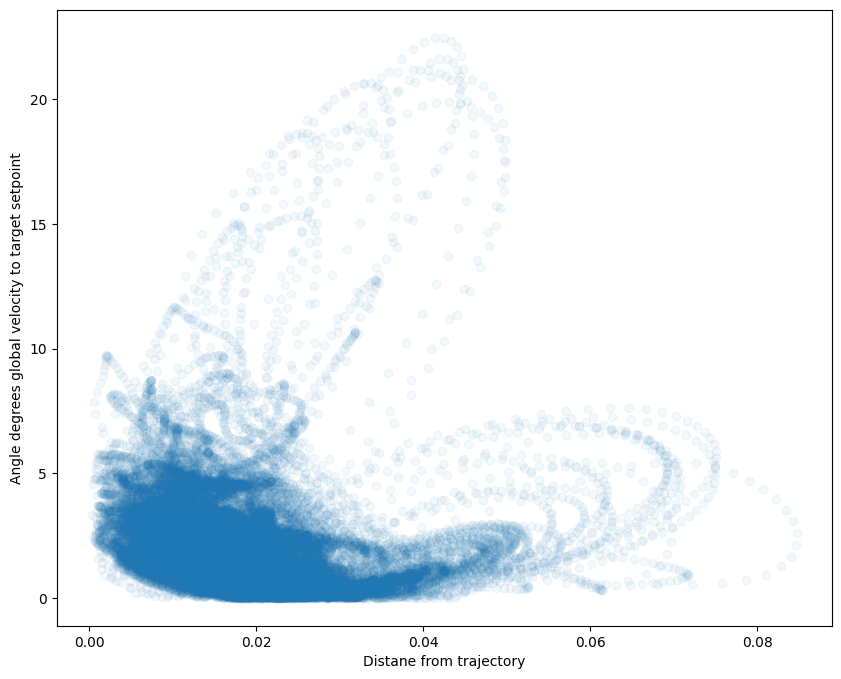

In [15]:
data_frame['dist_from_proj'] = np.linalg.norm(
    data_frame[['x','y','z']].to_numpy() - data_frame[['x_proj','y_proj','z_proj']].to_numpy(),
    axis=1
)

plt.hist(data_frame['dist_from_proj'], bins=75, weights=np.ones_like(data_frame['dist_from_proj'].to_numpy())/len(data_frame['dist_from_proj']))
plt.title('Distance from trajectory')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.xlim(0, 0.2)
plt.show()

data_frame['dx_sp'] = data_frame['x_sp'] - data_frame['x']
data_frame['dy_sp'] = data_frame['y_sp'] - data_frame['y']

a = data_frame[['dx_sp', 'dy_sp']].to_numpy() 
b = data_frame[['vx_global', 'vy_global']].to_numpy()
c = np.array([x.dot(y) for x,y in zip(a,b)])
cos_ = c / (np.linalg.norm(a, axis=1) * np.linalg.norm(b, axis=1))

d = (180/np.pi)*np.arccos(cos_) 

# plt.hist(d)
# plt.show()

plt.scatter(data_frame['dist_from_proj'], d, alpha=0.05)
plt.xlabel('Distane from trajectory')
plt.ylabel('Angle degrees global velocity to target setpoint')
plt.show()

/tmp/ipykernel_5605/714627654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_onchange['pass_error'] = np.linalg.norm(


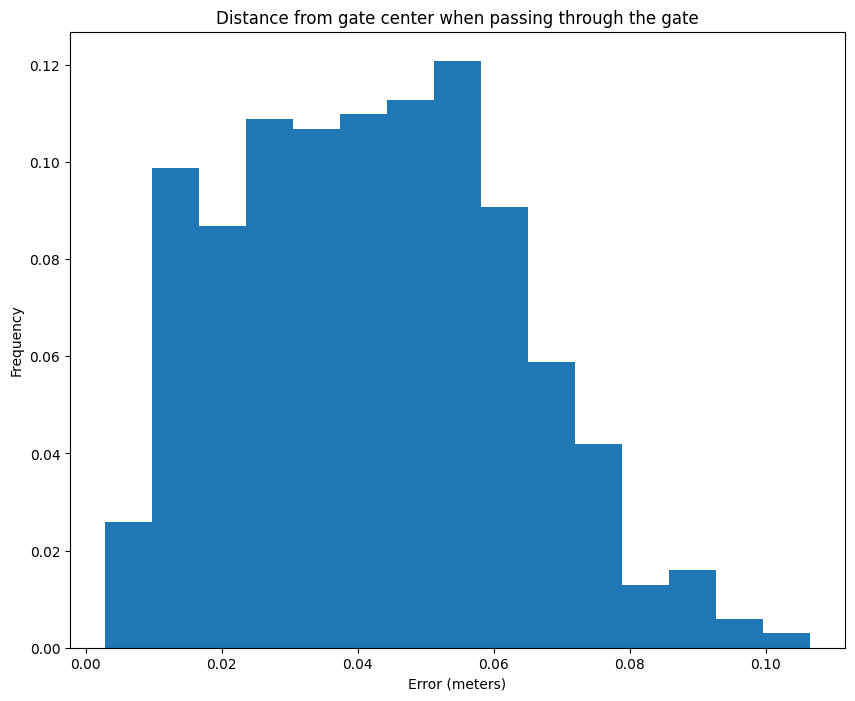

In [16]:
data_frame['change_gate'] = data_frame["gate_x"].to_numpy() != data_frame["gate_x"].shift(-1).to_numpy()

df_onchange = data_frame[data_frame['change_gate'] == True]
df_onchange['pass_error'] = np.linalg.norm(
    df_onchange[['x','y','z']].to_numpy() - df_onchange[['gate_x','gate_y','gate_z']].to_numpy(),
    axis=1
)

plt.hist(df_onchange['pass_error'], cumulative=False, bins=15, weights=np.ones_like(df_onchange['pass_error'].to_numpy())/len(df_onchange['pass_error']))
plt.title('Distance from gate center when passing through the gate')
plt.xlabel('Error (meters)')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_5605/2316381659.py:5: RuntimeWarning: invalid value encountered in arccos
  angle_vectors = np.arccos(cos_vectors) * (180/np.pi)


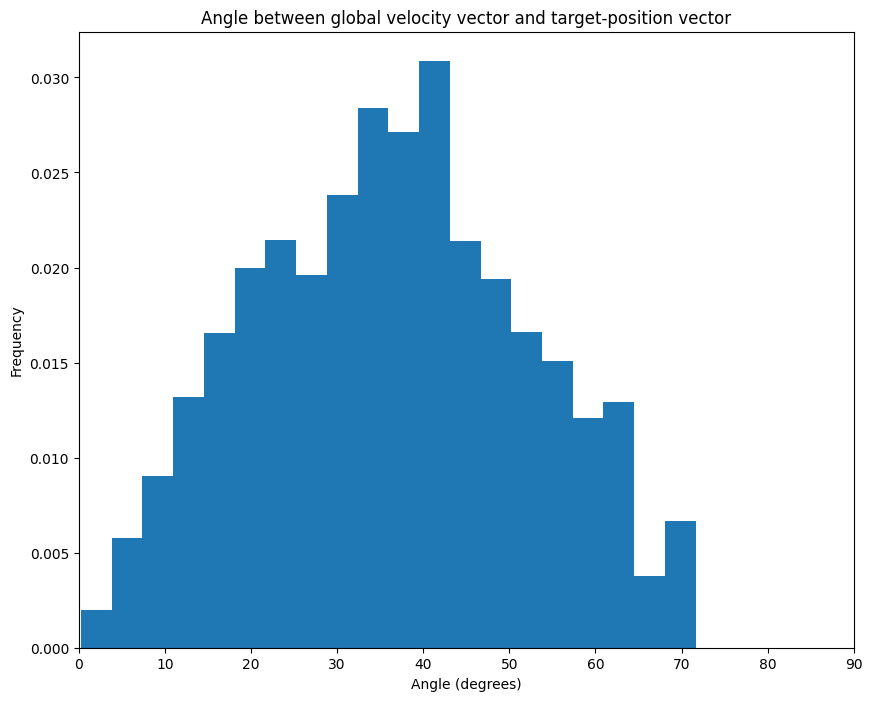

In [17]:
velocities = data_frame[["vx_global", "vy_global"]].to_numpy()
target_vector = data_frame[['x_sp','y_sp']].to_numpy() - data_frame[['x','y']].to_numpy()

cos_vectors = [np.dot(velocities[i], target_vector[i]) for i in range(len(velocities))]
angle_vectors = np.arccos(cos_vectors) * (180/np.pi)
plt.hist(angle_vectors, bins=20, weights=[1/len(angle_vectors) for _ in range(len(angle_vectors))])
plt.xlabel("Angle (degrees)")
plt.ylabel("Frequency")
plt.title("Angle between global velocity vector and target-position vector")
plt.xlim(0, 90)
plt.show()

(-0.5, 0.5)

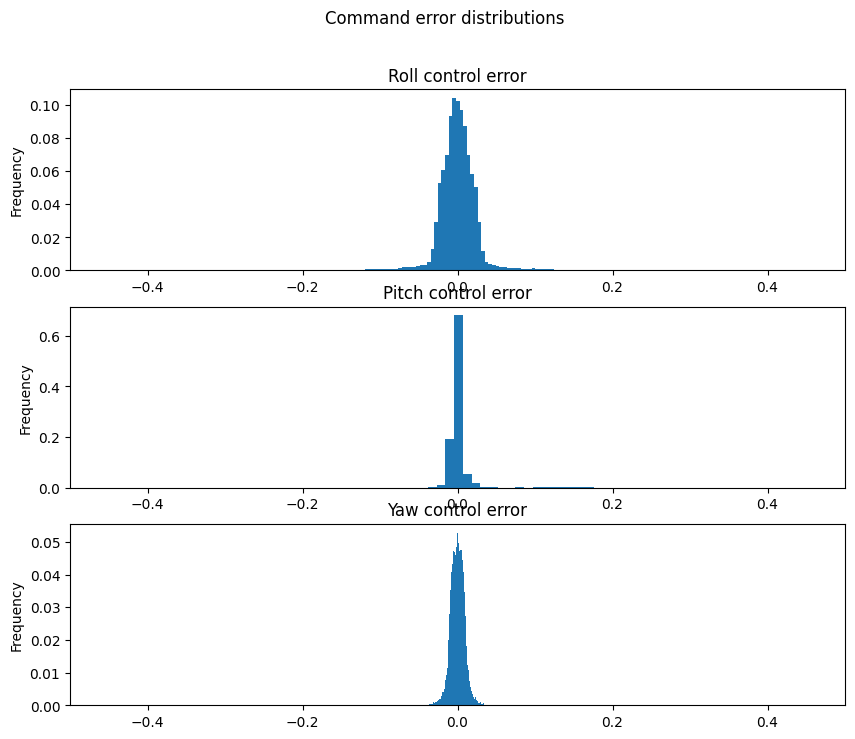

In [25]:
plt.rcParams['figure.figsize'] = 10,8
fig, axs = plt.subplots(3,1)
fig.suptitle("Command error distributions")

axs[0].hist(data_frame['roll_ctrl_error'], bins=100, weights=[1/len(data_frame) for _ in range(len(data_frame))])
axs[0].set_title('Roll control error')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(-0.5, 0.5)

axs[1].hist(data_frame['pitch_ctrl_error'], bins=100, weights=[1/len(data_frame) for _ in range(len(data_frame))])
axs[1].set_title('Pitch control error')
axs[1].set_ylabel('Frequency')
axs[1].set_xlim(-0.5, 0.5)

axs[2].hist(data_frame['yaw_rate_ctrl_error'], bins=100, weights=[1/len(data_frame) for _ in range(len(data_frame))])
axs[2].set_title('Yaw control error')
axs[2].set_ylabel('Frequency')
axs[2].set_xlim(-0.5, 0.5)


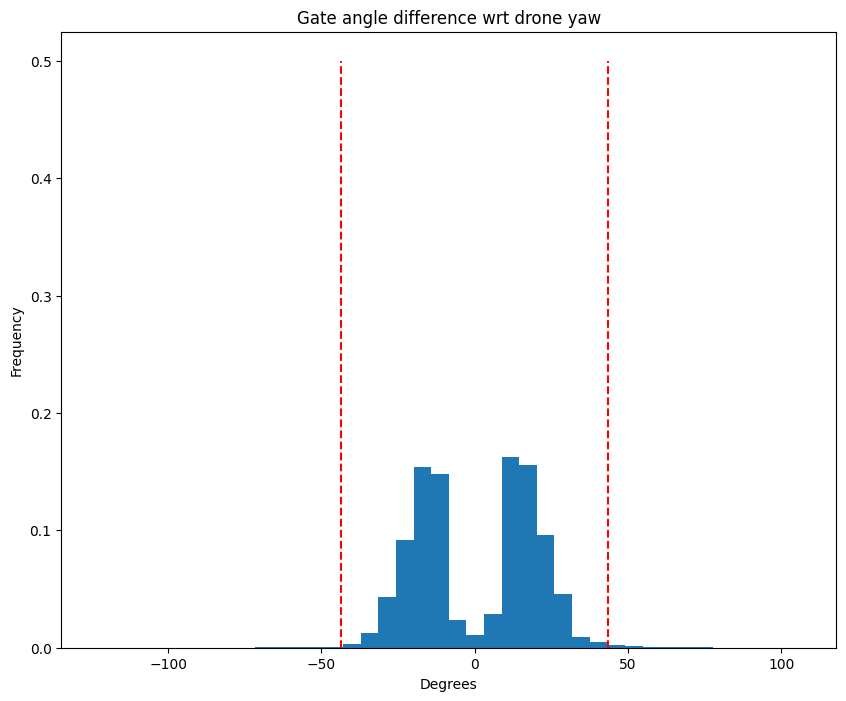

In [19]:
def wrap_to_pi(number):
    if number > np.pi:
        return number - 2 * np.pi
    elif number < -np.pi:
        return number + 2 * np.pi
    else:
        return number
    
a = data_frame[['gate_x','gate_y']].to_numpy() - data_frame[['x','y']].to_numpy()
ang_to_gate = np.array([math.atan2(x[1], x[0]) for x in a])
b = ang_to_gate - data_frame['yaw']
c = np.array([wrap_to_pi(x) for x in b])
c = c * (180/np.pi)

plt.hist(c, bins=40, weights=np.ones_like(c)/len(c))
plt.title('Gate angle difference wrt drone yaw')
plt.xlabel('Degrees')
plt.ylabel('Frequency')
plt.vlines((180/np.pi)*(1.52/2), 0, .5, colors='red', linestyles='--')
plt.vlines(-(180/np.pi)*(1.52/2), 0, .5, colors='red', linestyles='--')
plt.show()


[0 1 2 3 4 5] [  251  8630 21984  9769  1734   210]


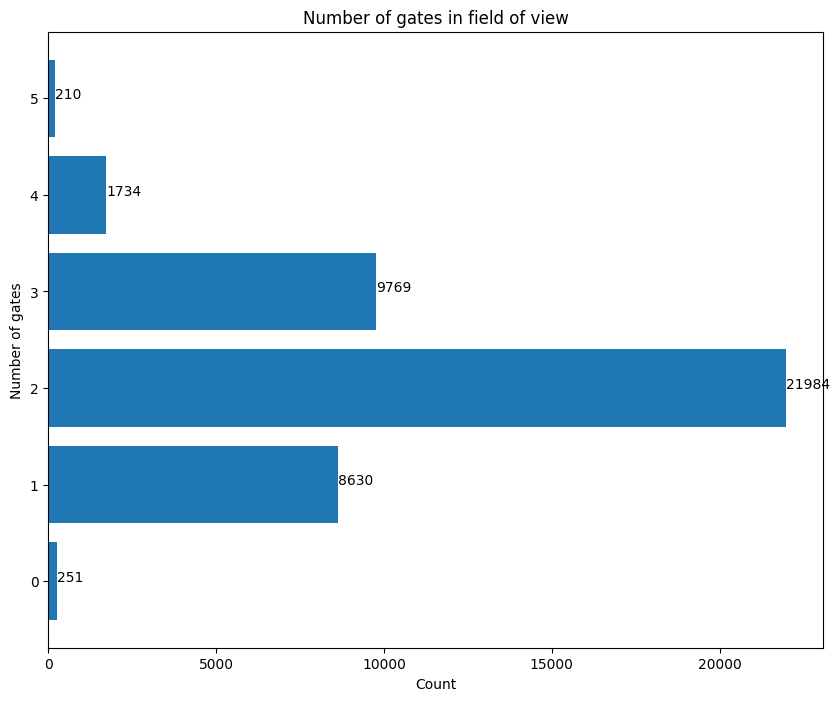

[False  True] [   36 33661]


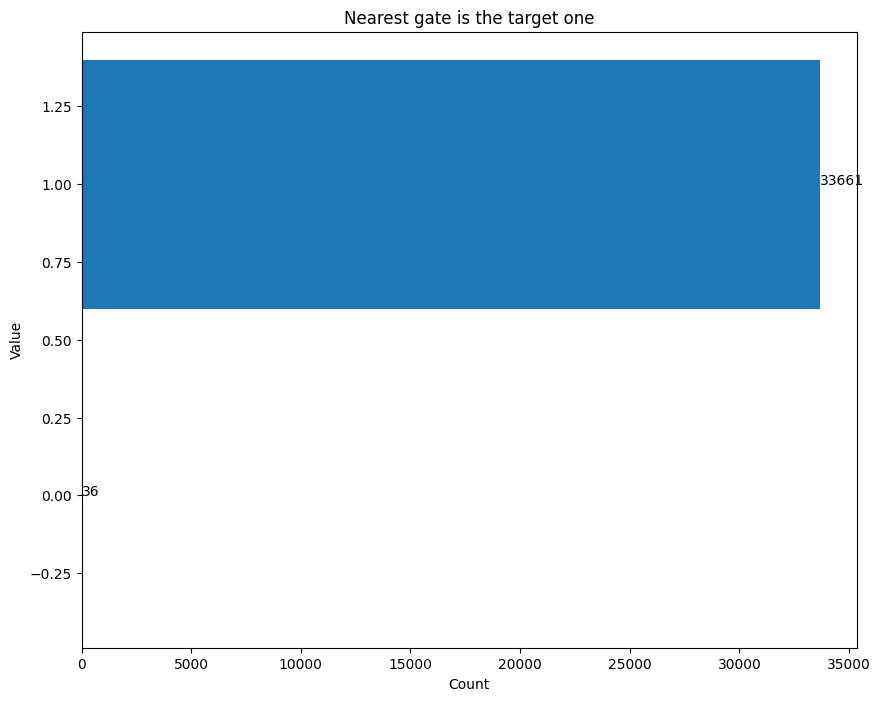

In [20]:
import tqdm
gb = data_frame.groupby(by='run_name')    
dfs = [gb.get_group(x) for x in gb.groups]

num_gates_in_fov = []
nearest_is_correct = []
for run in dfs:
    run_gates = run[['gate_x','gate_y']].drop_duplicates()
    run_gates_np = run_gates.to_numpy()

    for i in range(len(run)):
        row = run.iloc[i]
        pos = row[['x','y']].to_numpy()
        yaw = row['yaw']
        R = np.array([
            [math.cos(yaw), -math.sin(yaw)],
            [math.sin(yaw), math.cos(yaw)]
        ])

        relative_gates = run_gates_np - pos
        relative_gates = relative_gates.dot(R)

        i_gates_in_view = []
        gates_in_view = 0
        for j, g in enumerate(relative_gates):
            angle = math.atan2(g[1], g[0])
            if abs(angle) < 1.52/2:
                gates_in_view += 1
                i_gates_in_view.append(j)

        if gates_in_view > 1:
            correct_gate = run_gates_np == row[['gate_x','gate_y']].to_numpy()
            correct_gate = correct_gate[:, 0] & correct_gate[:, 1]
            correct_i = np.argmax(correct_gate)

            closest_i = -1
            min_distance = float('inf')
            for j in i_gates_in_view:
                dist = np.linalg.norm(relative_gates[j])
                if dist < min_distance:
                    min_distance = dist
                    closest_i = j

            nearest_is_correct.append(correct_i == closest_i)

        num_gates_in_fov.append(gates_in_view)


num, val = np.unique(num_gates_in_fov, return_counts=True)
print(num, val)
plt.barh(num, val)

for index, value in enumerate(val):
    plt.text(value, index,
             str(value))

plt.title('Number of gates in field of view')
plt.xlabel('Count')
plt.ylabel('Number of gates')
plt.show()

num, val = np.unique(nearest_is_correct, return_counts=True)
print(num,val)
plt.barh(num, val)

for index, value in enumerate(val):
    plt.text(value, index,
             str(value))

plt.title('Nearest gate is the target one')
plt.xlabel('Count')
plt.ylabel('Value')
plt.show()

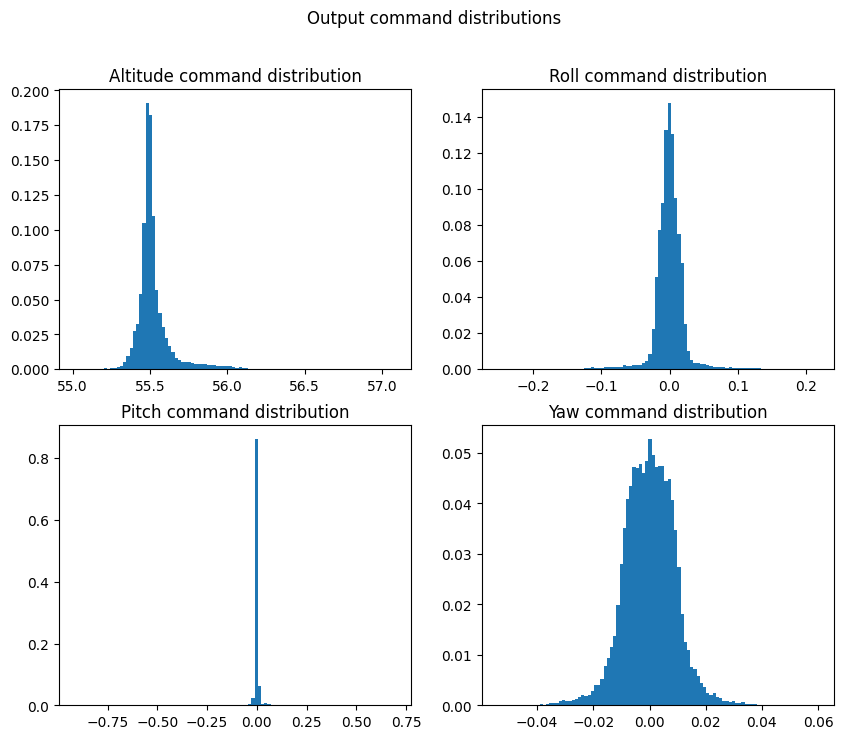

In [21]:
gb = data_frame.groupby(by='run_name')    
dfs = [gb.get_group(x) for x in gb.groups]

dcommands = []
for run in dfs:
    # print(run)
      a = run[['alt_command', 'roll_command','pitch_command', 'yaw_command']].to_numpy()
      dcommands.append(a)

dcommands = np.vstack(dcommands)
plt.rcParams['figure.figsize'] = 10,8
fig, axs = plt.subplots(2, 2)
fig.suptitle("Output command distributions")


axs[0,0].hist(dcommands[:, 0], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,0].set_title("Altitude command distribution")

axs[0,1].hist(dcommands[:, 1], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,1].set_title("Roll command distribution")

axs[1,0].hist(dcommands[:, 2], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,0].set_title("Pitch command distribution")

axs[1,1].hist(dcommands[:, 3], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,1].set_title("Yaw command distribution")

plt.show()

# plt.plot(dcommands[:, 0])

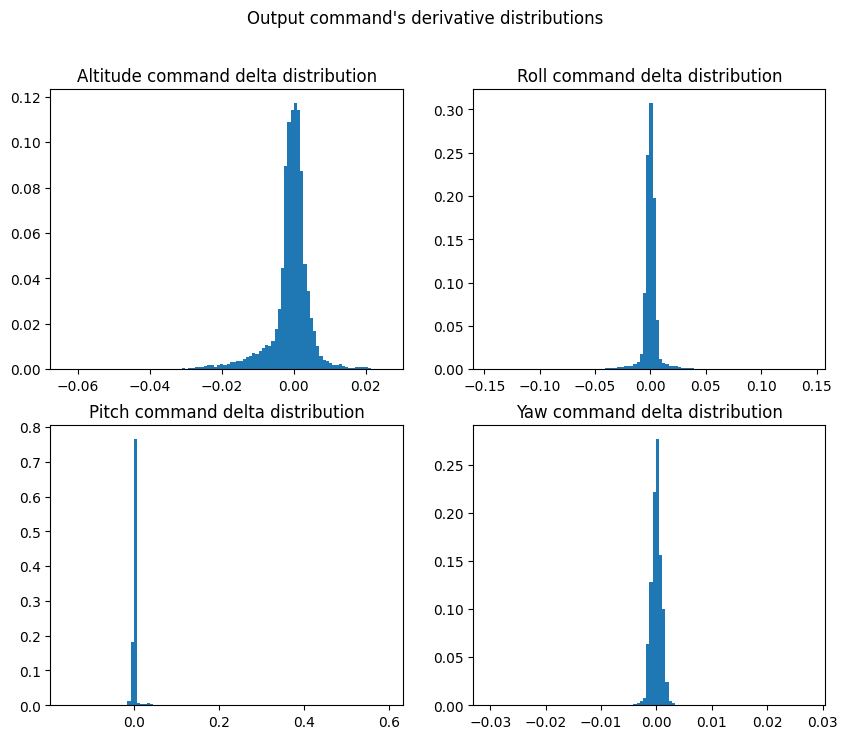

In [22]:
gb = data_frame.groupby(by='run_name')    
dfs = [gb.get_group(x) for x in gb.groups]

dcommands = []
for run in dfs:
    # print(run)
      a = run[['alt_command', 'roll_command','pitch_command', 'yaw_command']].to_numpy() -\
        run[['alt_command', 'roll_command','pitch_command', 'yaw_command']].shift(1).to_numpy()
      dcommands.append(a[1:])

dcommands = np.vstack(dcommands)
plt.rcParams['figure.figsize'] = 10,8
fig, axs = plt.subplots(2, 2)
fig.suptitle('Output command\'s derivative distributions')

axs[0,0].hist(dcommands[:, 0], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,0].set_title("Altitude command delta distribution")

axs[0,1].hist(dcommands[:, 1], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,1].set_title("Roll command delta distribution")

axs[1,0].hist(dcommands[:, 2], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,0].set_title("Pitch command delta distribution")

axs[1,1].hist(dcommands[:, 3], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,1].set_title("Yaw command delta distribution")

plt.show()

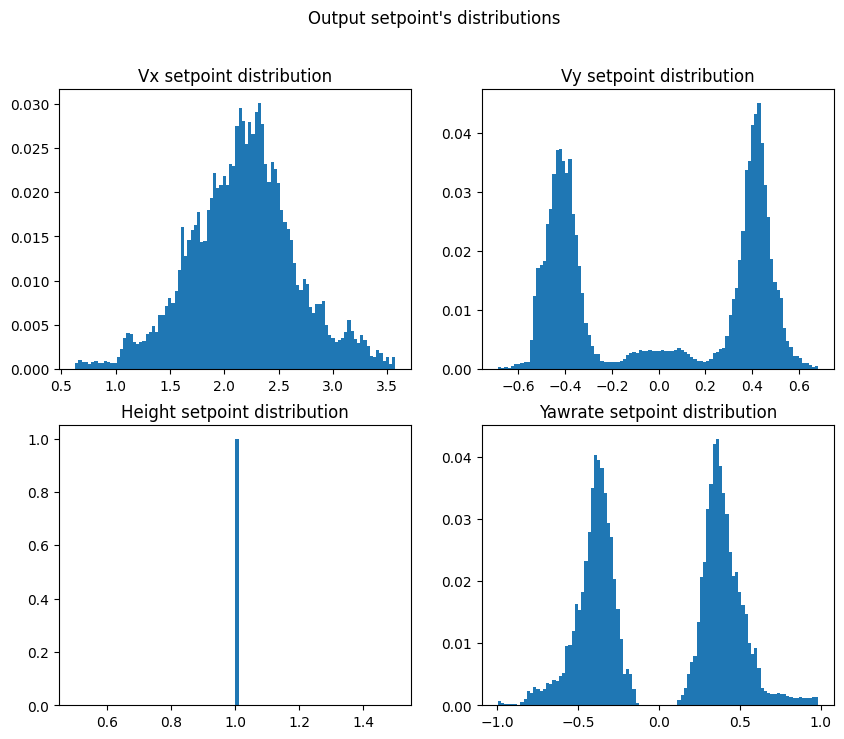

In [23]:
gb = data_frame.groupby(by='run_name')    
dfs = [gb.get_group(x) for x in gb.groups]

dcommands = []
for run in dfs:
    # print(run)
      a = run[['vx_local_sp', 'vy_local_sp','alt_sp', 'yaw_rate_sp']].to_numpy()
      dcommands.append(a)

dcommands = np.vstack(dcommands)
plt.rcParams['figure.figsize'] = 10,8
fig, axs = plt.subplots(2, 2)
fig.suptitle("Output setpoint's distributions")


axs[0,0].hist(dcommands[:, 0], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,0].set_title("Vx setpoint distribution")

axs[0,1].hist(dcommands[:, 1], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,1].set_title("Vy setpoint distribution")

axs[1,0].hist(dcommands[:, 2], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,0].set_title("Height setpoint distribution")

axs[1,1].hist(dcommands[:, 3], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,1].set_title("Yawrate setpoint distribution")

plt.show()

# plt.plot(dcommands[:, 0])

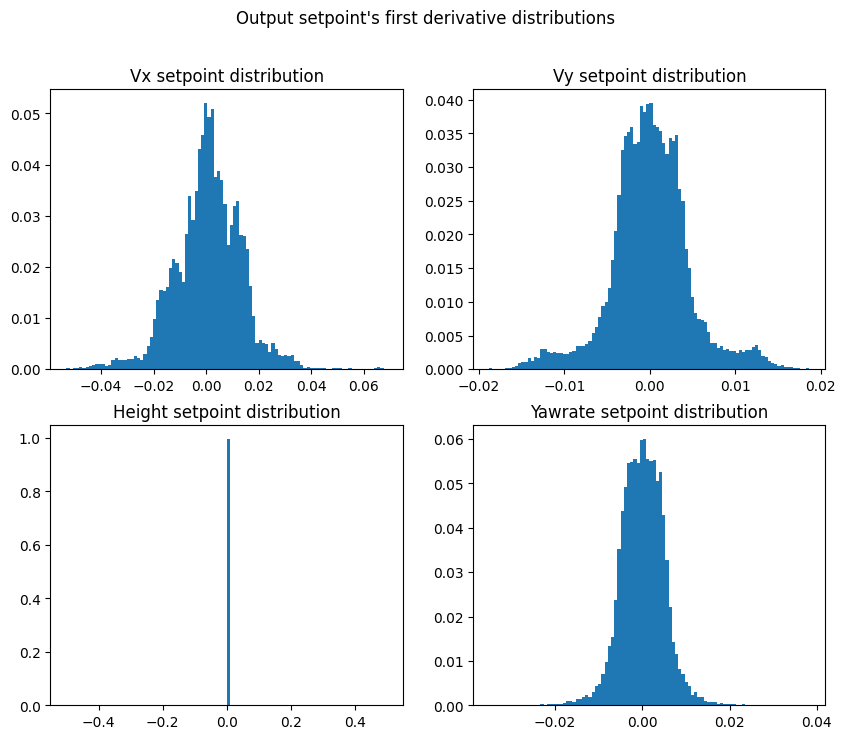

In [24]:
gb = data_frame.groupby(by='run_name')    
dfs = [gb.get_group(x) for x in gb.groups]

dcommands = []
for run in dfs:
    # print(run)
      a = run[['vx_local_sp', 'vy_local_sp','alt_sp', 'yaw_rate_sp']].to_numpy() - \
          run[['vx_local_sp', 'vy_local_sp','alt_sp', 'yaw_rate_sp']].shift(1).to_numpy()
      dcommands.append(a)


dcommands = np.vstack(dcommands)
plt.rcParams['figure.figsize'] = 10,8
fig, axs = plt.subplots(2, 2)
fig.suptitle("Output setpoint's first derivative distributions")


axs[0,0].hist(dcommands[:, 0], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,0].set_title("Vx setpoint distribution")

axs[0,1].hist(dcommands[:, 1], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[0,1].set_title("Vy setpoint distribution")

axs[1,0].hist(dcommands[:, 2], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,0].set_title("Height setpoint distribution")

axs[1,1].hist(dcommands[:, 3], bins=100, weights=[1/len(dcommands) for _ in range(len(dcommands))])
axs[1,1].set_title("Yawrate setpoint distribution")

plt.show()